# Train a Random Forest Regressor Model for multiple outputs
### Outputs include number of color source production as well as the number of lands in that deck

In [4]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit as sss

from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

import seaborn as sns

from joblib import dump, load

In [5]:
pd.options.display.max_columns = 20000
pd.set_option('display.width', 1000)

Get the input and output file paths

In [6]:
# Get the absolute path of the current working directory
current_dir = os.path.abspath(os.getcwd())

# Get the absolute path of the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

In [7]:
# Read in the input and output feather files
fp_input = os.path.join(parent_dir, 'data', 'input.feather')
fp_output = os.path.join(parent_dir, 'data', 'output.feather')

In [8]:
# Load the dataset using pandas
input = pd.read_feather(fp_input)
output = pd.read_feather(fp_output)

In [9]:
print(input)
print(output)

      avg_cmc  cast_cost_W  cast_cost_U  cast_cost_B  cast_cost_R  cast_cost_G  cast_cost_C  cast_cost_P  produces_W  produces_U  produces_B  produces_R  produces_G  produces_C  num_x_in_mana_cost  has_looting  has_carddraw  makes_treasure_tokens  reduced_spells  free_spells
0         3.5           17           25            0           20            0            0            0           0           0           0           0           0           0                   0            5            21                      4               4            4
1         2.2            0            0           28           14            0            0            0           0           0           0           0           0           0                   1            4            12                      6               0            0
2         3.1            3            3           19           10           14            0            0           2           2           2           2           6        

Stratify the input data based on the `avg_cmc` column to ensure a consistent distribution of test and train sets
This will help to reduce sampling bias

In [10]:
# Remove outliers where number of lands is less than 10 or greater than 40
outlier_indexes = output[(output['number_of_lands'] < 10) | (output['number_of_lands'] > 40)].index
# Use the drop method to remove the indexes from the DataFrame
output_no_outlier = output.drop(index=outlier_indexes)
input_no_outlier = input.drop(index=outlier_indexes)

In [11]:
input_no_outlier['cmc_cat'] = pd.qcut(input_no_outlier['avg_cmc'], q=5, labels=False)
input_no_outlier.groupby('cmc_cat')['avg_cmc'].agg(['min', 'max', 'count'])

,min,max,count
cmc_cat,,,
0,0.8,1.9,1784
1,2.0,2.2,1632
2,2.3,2.5,1635
3,2.6,3.0,1718
4,3.1,11.3,1370


In [12]:
input_no_outlier

,avg_cmc,cast_cost_W,cast_cost_U,cast_cost_B,cast_cost_R,cast_cost_G,cast_cost_C,cast_cost_P,produces_W,produces_U,produces_B,produces_R,produces_G,produces_C,num_x_in_mana_cost,has_looting,has_carddraw,makes_treasure_tokens,reduced_spells,free_spells,cmc_cat
0,3.5,17,25,0,20,0,0,0,0,0,0,0,0,0,0,5,21,4,4,4,4
1,2.2,0,0,28,14,0,0,0,0,0,0,0,0,0,1,4,12,6,0,0,1
2,3.1,3,3,19,10,14,0,0,2,2,2,2,6,0,0,0,11,4,0,0,4
3,2.6,51,0,0,0,4,0,0,4,0,0,0,0,0,3,0,0,0,0,0,3
4,2.1,0,10,23,0,23,0,0,0,0,0,0,0,0,0,0,8,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9293,1.8,0,31,2,14,0,0,1,2,3,3,3,2,0,0,0,18,2,0,0,0
9294,2.4,0,29,11,6,0,0,2,2,2,2,2,2,3,0,0,14,0,0,0,2
9295,1.6,0,12,26,2,0,0,0,3,3,11,3,3,3,1,0,9,0,0,0,0
9296,2.4,0,35,3,0,0,0,2,2,2,2,2,2,6,0,0,10,0,0,0,2


In [13]:
# Stratify the input data to preserve the cmc distribution in training and testing set
split = sss(n_splits=1, test_size=0.2, random_state=69)

for train_index, test_index in split.split(input_no_outlier, input_no_outlier['cmc_cat']):
    X_train = input_no_outlier.iloc[train_index]
    X_test = input_no_outlier.iloc[test_index]
    y_train = output_no_outlier.iloc[train_index]
    y_test = output_no_outlier.iloc[test_index]

In [14]:
for set in (X_train, X_test):
    try:
        set.drop(['cmc_cat'], axis=1, inplace=True)
    except:
        continue

C:\Users\Peter\AppData\Local\Temp\ipykernel_15036\1481156034.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set.drop(['cmc_cat'], axis=1, inplace=True)
C:\Users\Peter\AppData\Local\Temp\ipykernel_15036\1481156034.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set.drop(['cmc_cat'], axis=1, inplace=True)


array([[<Axes: title={'center': 'avg_cmc'}>,
        <Axes: title={'center': 'cast_cost_W'}>,
        <Axes: title={'center': 'cast_cost_U'}>,
        <Axes: title={'center': 'cast_cost_B'}>,
        <Axes: title={'center': 'cast_cost_R'}>],
       [<Axes: title={'center': 'cast_cost_G'}>,
        <Axes: title={'center': 'cast_cost_C'}>,
        <Axes: title={'center': 'cast_cost_P'}>,
        <Axes: title={'center': 'produces_W'}>,
        <Axes: title={'center': 'produces_U'}>],
       [<Axes: title={'center': 'produces_B'}>,
        <Axes: title={'center': 'produces_R'}>,
        <Axes: title={'center': 'produces_G'}>,
        <Axes: title={'center': 'produces_C'}>,
        <Axes: title={'center': 'num_x_in_mana_cost'}>],
       [<Axes: title={'center': 'has_looting'}>,
        <Axes: title={'center': 'has_carddraw'}>,
        <Axes: title={'center': 'makes_treasure_tokens'}>,
        <Axes: title={'center': 'reduced_spells'}>,
        <Axes: title={'center': 'free_spells'}>],
     

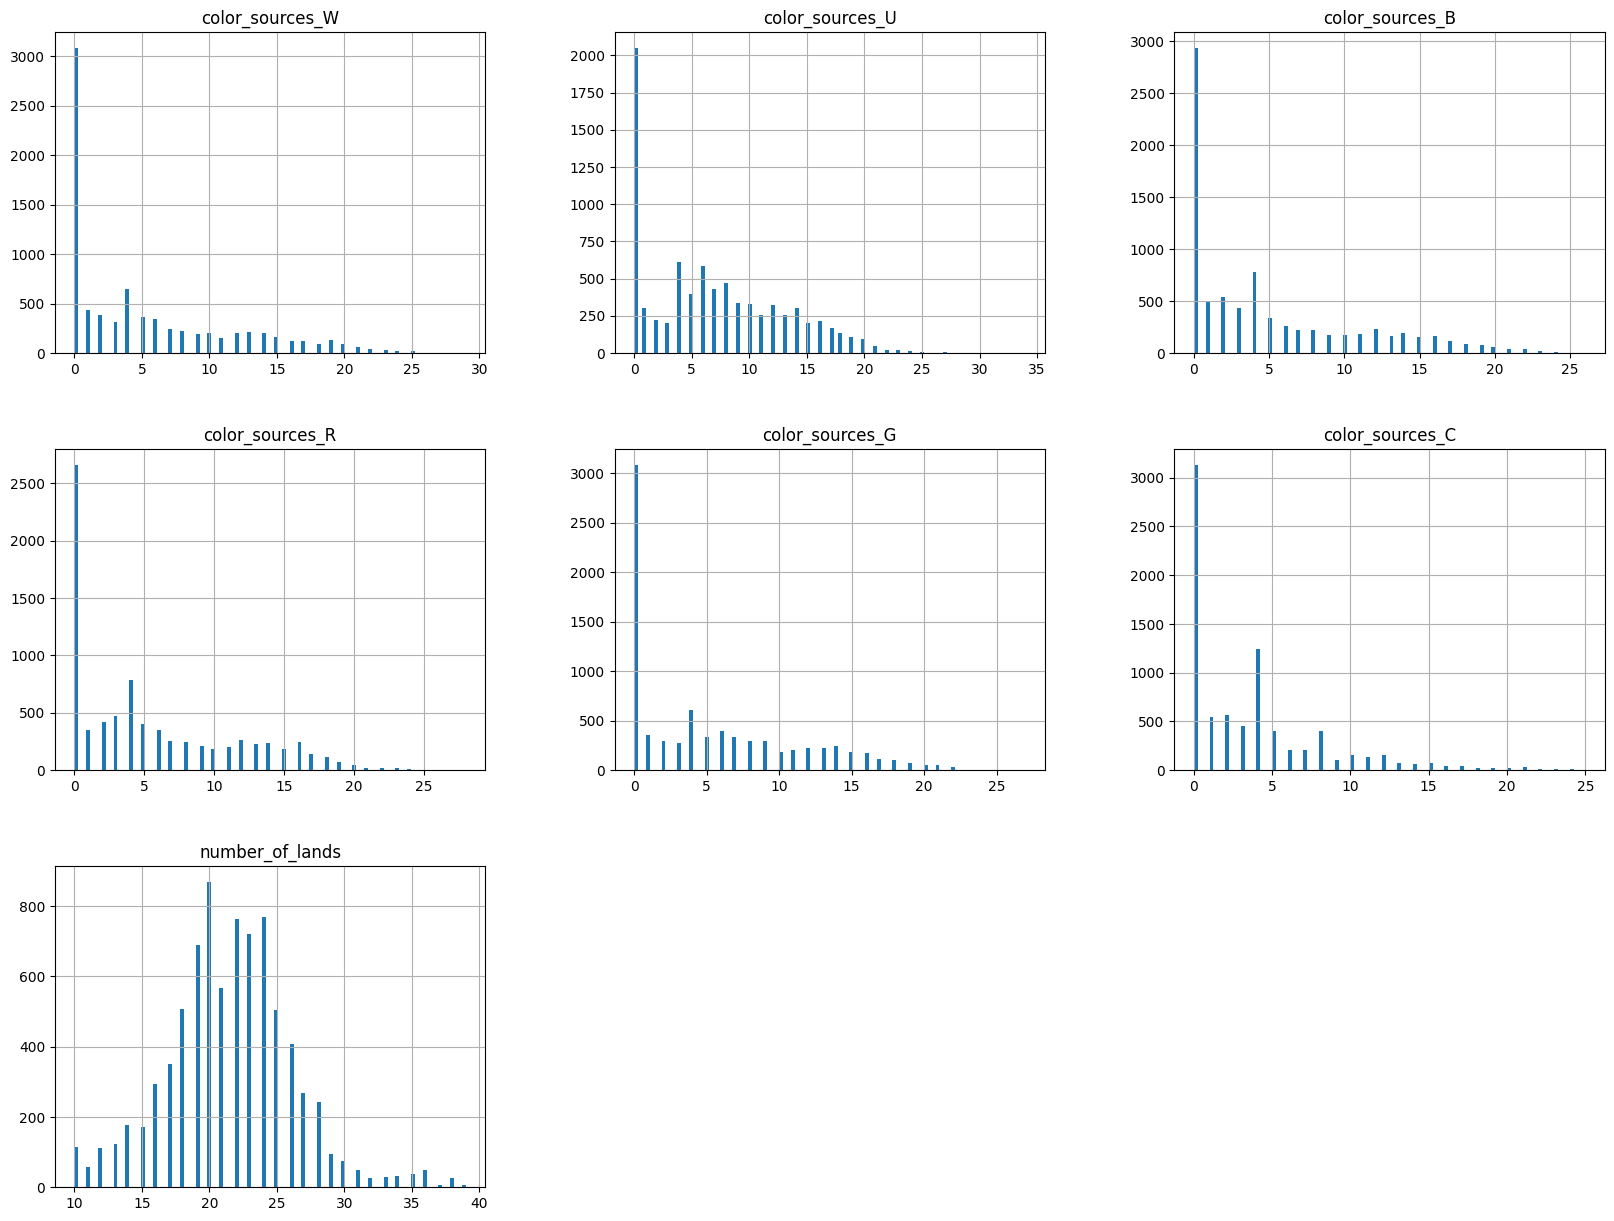

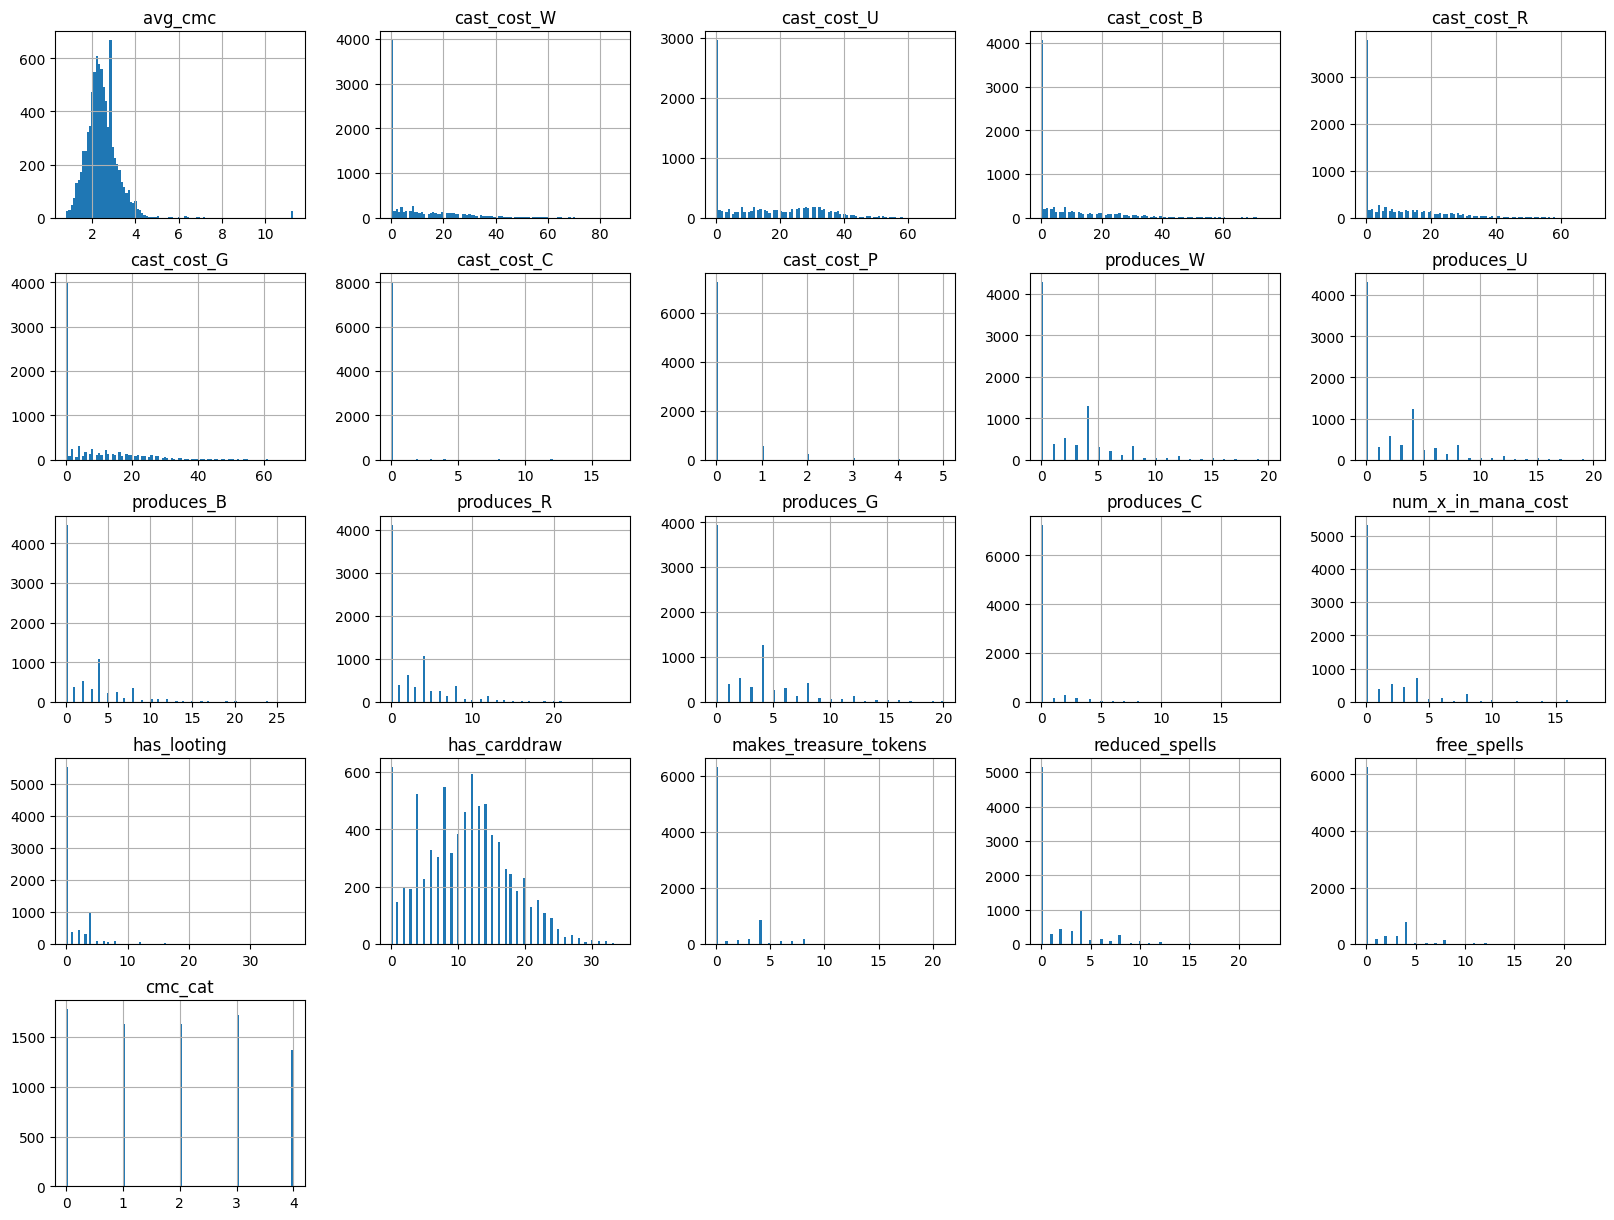

In [247]:
output_no_outlier.hist(bins=100, figsize=(20,15))
input_no_outlier.hist(bins=100, figsize=(20,15))

We can view the relationships between all of the features

In [ ]:
# Combine the input and output data into a single dataframe
data = pd.concat([input, output], axis=1)

# Plot the pairwise scatterplots
sns.pairplot(data)

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.2, random_state=42)

Train a multi-output model with no hyperparameter tuning

In [ ]:
# Instantiate the RandomForestRegressor
rf_regressor_1 = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_regressor_1.fit(X_train, y_train)

# Predict the target values for both the training and testing data
y_train_pred = rf_regressor_1.predict(X_train)
y_test_pred = rf_regressor_1.predict(X_test)

# Calculate the evaluation metrics for the training and testing data
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

Evaluate the base model across different metrics

In [ ]:
# Print the evaluation metrics
print(f"Training MAE: {mae_train:.2f}")
print(f"Testing MAE: {mae_test:.2f}")

print(f"Training MSE: {mse_train:.2f}")
print(f"Testing MSE: {mse_test:.2f}")

print(f"Training R^2: {r2_train:.2f}")
print(f"Testing R^2: {r2_test:.2f}")

Training MAE: 0.41
Testing MAE: 1.07
Training MSE: 0.56
Testing MSE: 3.82
Training R^2: 0.98
Testing R^2: 0.87


Perform Grid-search to find the optimal hyperparameter values

In [ ]:
# Define the hyperparameters grid to search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Instantiate the RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=42)

# Instantiate the GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_hyperparams = grid_search.best_params_
print(f"Best hyperparameters: {best_hyperparams}")

# Get the best model (fitted with the optimal hyperparameters)
best_model = grid_search.best_estimator_

# Predict the target values for the testing data
y_test_pred = best_model.predict(X_test)

# Calculate the evaluation metrics for the testing data
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Testing MAE: {mae_test:.2f}")
print(f"Testing MSE: {mse_test:.2f}")
print(f"Testing R^2: {r2_test:.2f}")

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Testing MAE: 1.07
Testing MSE: 3.81
Testing R^2: 0.87


Plot the feature importances

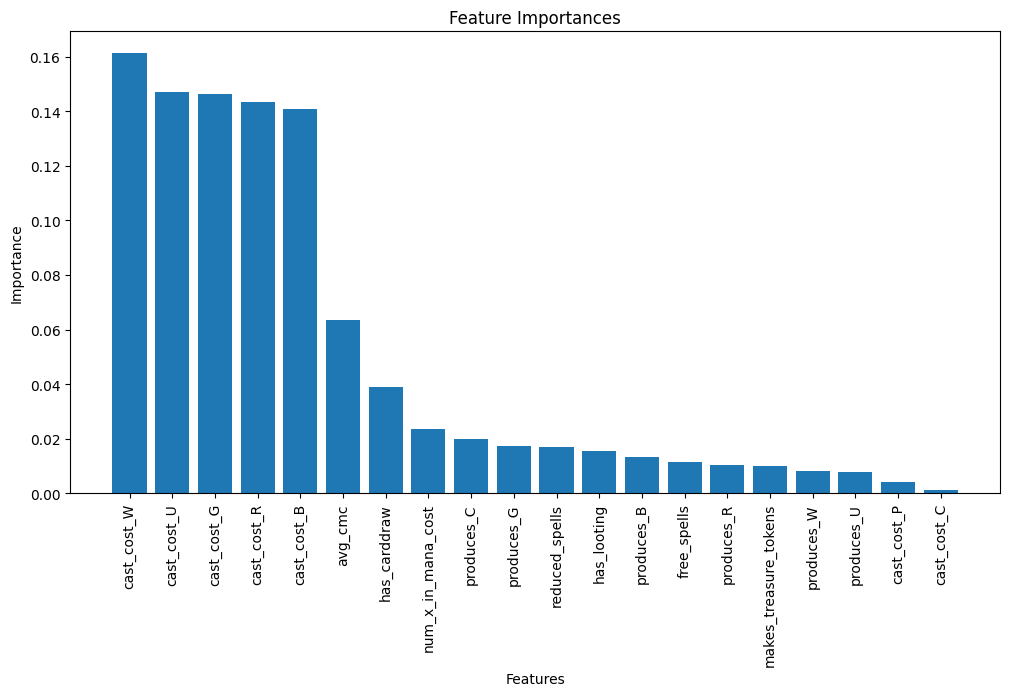

In [ ]:
# Get feature importances from the best model
importances = best_model.feature_importances_
feature_importances = list(zip(input.columns, importances))

# Sort the feature importances in descending order
feature_importances.sort(key=lambda x: x[1], reverse=True)

# Separate the feature names and their importances
features, importances = zip(*feature_importances)

# Create a bar plot of feature importances
plt.figure(figsize=(12, 6))
plt.bar(features, importances)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

Train a 2nd degree model

In [66]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
poly_features = poly.fit_transform(input_no_outlier)

# Get the feature names from the PolynomialFeatures object
feature_names = poly.get_feature_names_out(input_features=input_no_outlier.columns)

# Create a new DataFrame with the polynomial features
input_poly = pd.DataFrame(poly_features, columns=feature_names)

In [67]:
rf_model_poly = RandomForestRegressor(
    max_depth= 30, 
    min_samples_leaf = 1,
    min_samples_split = 2,
    n_estimators = 200)

poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

rf_model_poly.fit(X_train_poly, y_train)

y_train_pred = rf_model_poly.predict(X_train_poly)
y_test_pred = rf_model_poly.predict(X_test_poly)

In [68]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

View the mean squared error and mean absolute errors

In [69]:
print(f'train mean_squared_error:\t{train_mse}')
print(f'test mean_squared_error:\t{test_mse}')
print('\n')
print(f'train mean_absolute_error:\t{train_mae}')
print(f'test mean_absolute_error:\t{test_mae}')

train mean_squared_error:	0.5393873013776991
test mean_squared_error:	3.8344467600944916


train mean_absolute_error:	0.4057027550485298
test mean_absolute_error:	1.079055748453231


Plot the relationship between the actual vs. predicted values

In [72]:
mae_errors = np.abs(y_test - y_test_pred)
print(type(mae_errors))
print(type(y_test))
print(type(y_test_pred))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


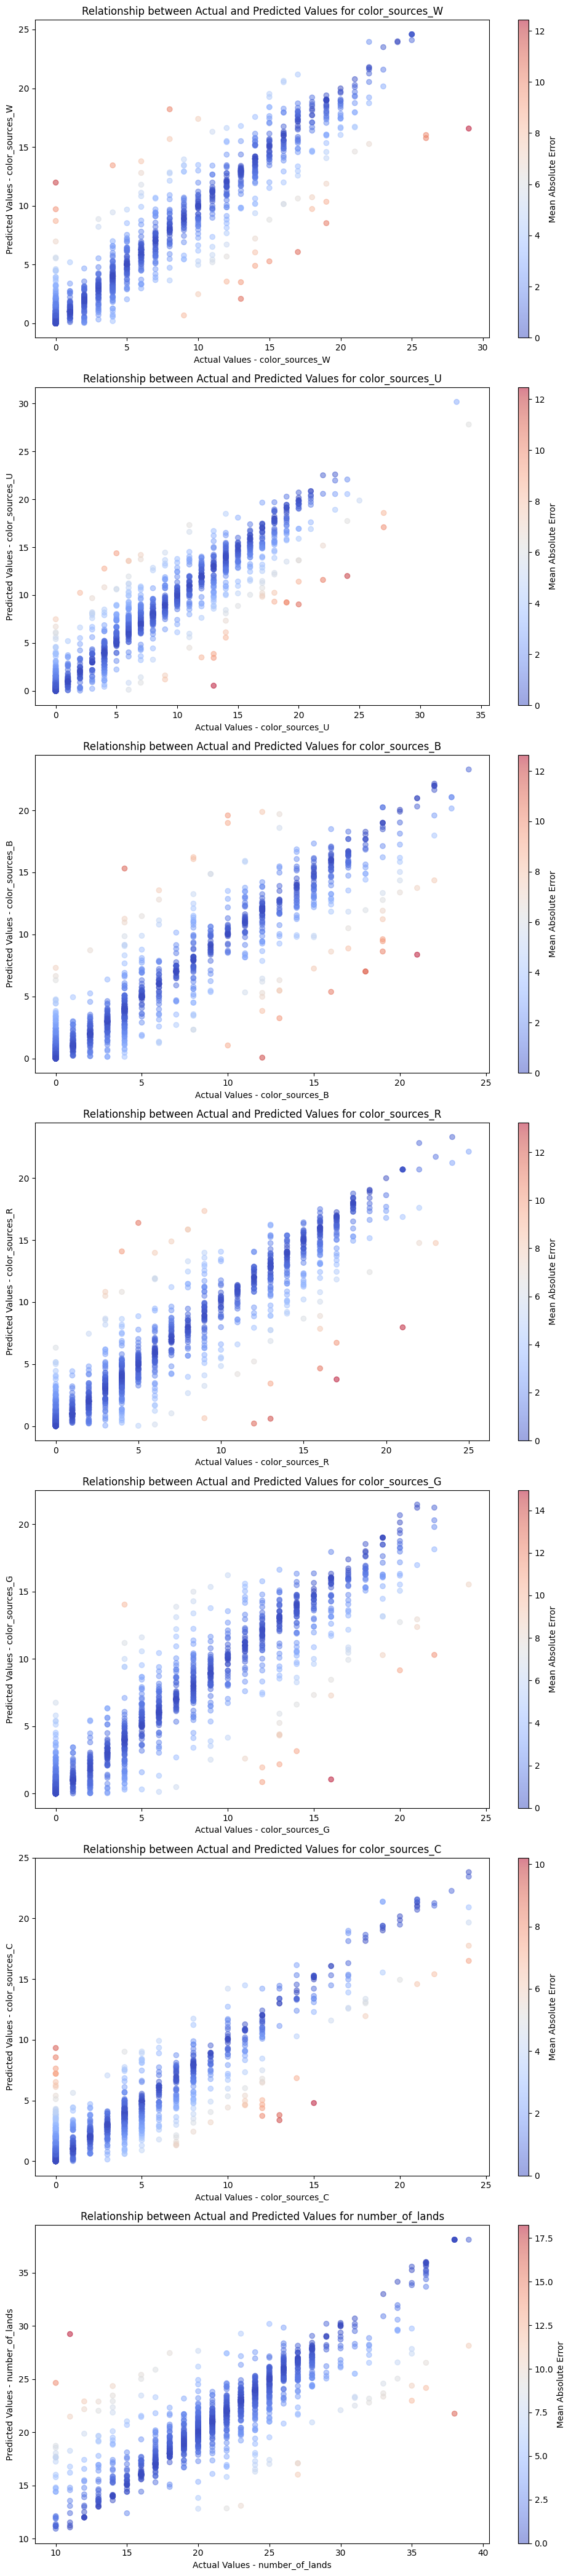

In [76]:
# Calculate the mean absolute errors for each prediction
mae_errors = np.abs(y_test - y_test_pred)

# Plot the scatter plot for each dimension
n_dimensions = mae_errors.shape[1]
fig, axes = plt.subplots(n_dimensions, 1, figsize=(10, 6 * n_dimensions))

# # Convert y_test from a numpy array to a pandas DataFrame
# y_test_pred = pd.DataFrame(y_test, columns=output.columns)

for i in range(n_dimensions):
    output_feature_name = y_test.columns[i]
    sm = axes[i].scatter(y_test.iloc[:, i], y_test_pred[:, i], c=mae_errors.iloc[:, i], cmap='coolwarm', alpha=0.5)
    axes[i].set_xlabel(f'Actual Values - {output_feature_name}')
    axes[i].set_ylabel(f'Predicted Values - {output_feature_name}')
    axes[i].set_title(f'Relationship between Actual and Predicted Values for {output_feature_name}')
    plt.colorbar(sm, ax=axes[i], label='Mean Absolute Error', aspect=30)

plt.tight_layout()
plt.show()

In [77]:
# Save the compressed model to disk
dump(rf_model_poly, 'C:/Users/Peter/Documents/GitHub/MTG-Land-Recommender/rf_multi_poly_model_no_outliers.joblib.z', compress=True)

['C:/Users/Peter/Documents/GitHub/MTG-Land-Recommender/rf_multi_poly_model_no_outliers.joblib.z']